# Logistische Regression: digits

Dieses Jupyter Notebook führt die Ergebnisse des zweiten Projektes im Modul Special Engineering (M30) zum Thema Logistische Regression auf. Als Datenset wird das digits Datenset verwendet.

In [69]:
###############################################################################
# Digits Dataset: Logistische Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix

import time
import keras

from sklearn.datasets import load_digits
from scipy.stats.kde import gaussian_kde

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



### Visualisieren von einzelnen Ziffern
Nachdem das Datenset geladen wurde, können vereinzelte Zahlen illustriert werden.

In [ ]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.inferno)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

Zu sehen ist, dass die selben Ziffern häufig minimale Unterschiede untereinander haben. Die Zeilen 3 und 4 wirken stark frequentiert, hingegen die Spalten 0 und 7 sehr schwach.

Anzumerken ist noch, dass die Features des Datensets, aufgrund der Tatsache, dass es sich ausschlißelich um Helligkeitswerte handelt, bereits skaliert sind.
Ein erneutes skalieren ist somit nicht unbedingt Notwendig aber dennoch ratsam, da das Gradientenabstiegsverfahren wohl deutlich schneller Konvergiert.
https://en.wikipedia.org/wiki/Feature_scaling#cite_note-1

In [ ]:
mean, std = lr.StandardScaler_fit(X)
print(mean,std)
#X = lr.StandardScaler_transform(X, mean, std+10)
#print(np.max(X),np.min(X))

Auffälig ist dennoch,wenn man sich den Mittelwert und die Standartabweichung der einzelnen Features anschaut, fällt nochmals auf, dass beide bei drei Features jeweils 0.0 ist, was eigentlich bedeuted, dass es zwischen den einzelnen digits bei diesen Features keine Unterschiede gibt, welche für Verhersagungen genutz werden können.
Somit könnten diese drei Features komplett ausgeschlossen werden um ggf. Prozessorzeit oder Speicher zu sparen.

In [76]:
####################
# split dataset (80:20)
####################


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

print('trainset ',np.shape(X_train),np.shape(y_train),
      '\ntestset ', np.shape(X_test),np.shape(y_test),
      '\nvalidationset ',np.shape(X_val),np.shape(y_val))

trainset  (1078, 64) (1078,) 
testset  (359, 64) (359,) 
validationset  (360, 64) (360,)


<ipython-input-77-158c03fbe848>:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax2.stem([0],[0.1], '-.')


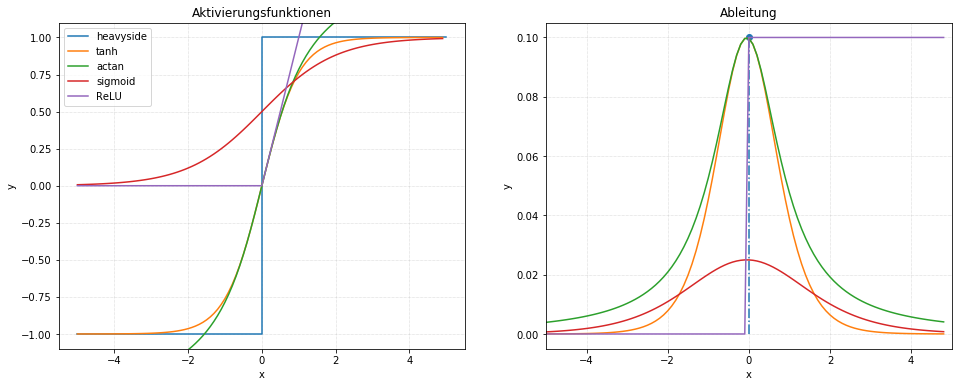

In [77]:
from scipy.special import expit, logit


x = np.arange(-5, 5, .1)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#step
ax1.step([-5,5],[-1,1], where='mid')
#tanh
ax1.plot(x, np.tanh(x))
#arctan
ax1.plot(x, np.arctan(x))
#sigmoid
ax1.plot(x, expit(x))
#ReLU
ax1.plot(x, np.maximum(0, x))
ax1.set_ylim([-1.1, 1.1])
#ax1.set_xlim([-1.1, 1.1])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(linestyle=':', linewidth=0.5)
ax1.legend(['heavyside','tanh','actan','sigmoid','ReLU'])
ax1.title.set_text('Aktivierungsfunktionen')


#step
ax2.stem([0],[0.1], '-.')
#tanh
ax2.plot(x[:-1], np.diff(np.tanh(x)))
#arctan
ax2.plot(x[:-1], np.diff(np.arctan(x)))
#sigmoid
ax2.plot(x[:-1], np.diff(1 / (1 + np.exp(-x))))
#ReLU
ax2.plot(x[:-1], np.diff(np.maximum(0, x)))
#ax2.set_ylim([-1.1, 1.1])
ax2.set_xlim([-5, 5])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(linestyle=':', linewidth=0.5)
ax2.title.set_text('Ableitung')

plt.show()




Lineare Aktivierungsfunktionen unterliegen einer starken Beschränkung, da eine Komposition linearer Funktionen durch arithmetische Umformungen durch eine einzige lineare Funktion dargestellt werden kann. Für mehrschichtige Verbindungsnetzwerke sind sie deswegen nicht geeignet und finden so nur in einfachen Modellen Anwendung. 

In [ ]:
####################
# explore trainingset
####################

# Häufigkeitsverteilung y (target)
fig = plt.figure(figsize=(9, 8))

labels, counts = np.unique(y_train, return_counts=True)

print(labels,'\n',counts)

plt.bar(labels, counts, align='center', width=0.95)
plt.gca().set_xticks(labels)
plt.xlabel('digit')
plt.xlim(-1,10)
plt.ylabel('count')
plt.title('relative Häufigkeitsverteilung der digits der Trainingsdaten')
plt.grid(color='0.75', linestyle='-.', linewidth=1, axis='y')
plt.show()

Zu sehen ist die Klassenverteilung des Datensets. Anzumerken ist, dass bis auf Klasse 0 und Klasse 1 die Anzahl bei jeder Klassen unterschiedlich ist. Die Klassen des Datensets also nicht ausgeglichen sind.

In [ ]:
for im in images:
    print(im)
    print(im.reshape(1,-1))

In [ ]:
mean_train, std_train = [], []
coeffs = []

y_train = dataset.target


labels = np.arange(-0,17,1)
xmax = 16.4
xmin = -0.4

for ind, im in enumerate(images):

    im = im.reshape(1,-1)
    # print(df[col].describe())
    #mean, std = lr.StandardScaler_fit(im)
    #mean_train.append(mean)
    #std_train.append(std)
    print(f'feature {ind} ({ind}):')
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('black value')
    ax.set_ylabel("count")
    ax.set_title(f"Histogramm der Helligkeitswerte: feature {ind}")
    
    label, counts = np.unique(im, return_counts=True)

    ax.bar(label, counts, align='center', width=0.5)
    ax.set_xticks(labels)
    ax.set_xlim(xmin,xmax)
    ##
    ##
    
    
   # mat = np.array([[col],[y_train]])
    
    # Verteilungsdichte bestimmen
    # random offset um die covarianz numerisch betimmen zu können
    rand = 0.0001*np.random.rand(np.size(im,0))-0.0001
    # KDE
    k = gaussian_kde(np.vstack([im+rand, y_train]))
    xi, yi = np.mgrid[xmin:xmax:im.size**0.4*1j, y_train.min()-0.5:y_train.max()+0.5:y_train.size**0.3333*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax2 = plt.subplot(gs[1])
    ax2.set_xlabel('black value')
    ax2.set_ylabel("digit")
    ax2.set_xticks(labels)
    ax2.set_yticks(targets)
    ax2.set_ylim(-0.5,9.5)
    ax2.set_xlim(xmin,xmax)
    #im = ax2.matshow(mat)
    
    #plot density
    #ax2.scatter(col, y_train, alpha=0.1)#, c=col, cmap=cm.cividis)
    #im = ax2.pcolormesh(xedges, yedges, Z.T)
    im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cm.inferno, alpha=1)#cm.cividis GnBu YlOrBr viridis magma
    plt.colorbar(im)
    
    ##
    coeff = np.mean(np.corrcoef(col, y_train.T))
    coeffs.append(coeff)
    ax2.set_title(f"Dichteverteilung der Helligkeitswerte feature {ind} je digit")
    plt.show()

    #Feature beschreiben
    print(f'rows = {np.size(col)}\nall numeric = {not np.isnan(col).any()} ({col.dtype})\nmean = {mean}\nstd = {std}\nmax|min = {np.max(col)}|{np.min(col)}', '\n', '\n')


In [ ]:
mean_train, std_train = [], []
coeffs = []



labels = np.arange(-0,17,1)
xmax = 16.4
xmin = -0.4

for ind, col in enumerate(X_train.T):

    # print(df[col].describe())
    mean, std = lr.StandardScaler_fit(col)
    mean_train.append(mean)
    std_train.append(std)
    print(f'feature {ind} ({ind}):')
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('black value')
    ax.set_ylabel("count")
    ax.set_title(f"Histogramm der Helligkeitswerte: feature {ind}")
    
    label, counts = np.unique(col, return_counts=True)

    ax.bar(label, counts, align='center', width=0.5)
    ax.set_xticks(labels)
    ax.set_xlim(xmin,xmax)
    ##
    ##
    
    
   # mat = np.array([[col],[y_train]])
    
    # Verteilungsdichte bestimmen
    # random offset um die covarianz numerisch betimmen zu können
    rand = 0.0001*np.random.rand(np.size(col,0))-0.0001
    # KDE
    k = gaussian_kde(np.vstack([col+rand, y_train]))
    xi, yi = np.mgrid[xmin:xmax:col.size**0.4*1j, y_train.min()-0.5:y_train.max()+0.5:y_train.size**0.3333*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax2 = plt.subplot(gs[1])
    ax2.set_xlabel('black value')
    ax2.set_ylabel("digit")
    ax2.set_xticks(labels)
    ax2.set_yticks(targets)
    ax2.set_ylim(-0.5,9.5)
    ax2.set_xlim(xmin,xmax)
    #im = ax2.matshow(mat)
    
    #plot density
    #ax2.scatter(col, y_train, alpha=0.1)#, c=col, cmap=cm.cividis)
    #im = ax2.pcolormesh(xedges, yedges, Z.T)
    im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cm.inferno, alpha=1)#cm.cividis GnBu YlOrBr viridis magma
    plt.colorbar(im)
    
    ##
    coeff = np.mean(np.corrcoef(col, y_train.T))
    coeffs.append(coeff)
    ax2.set_title(f"Dichteverteilung der Helligkeitswerte feature {ind} je digit")
    plt.show()

    #Feature beschreiben
    print(f'rows = {np.size(col)}\nall numeric = {not np.isnan(col).any()} ({col.dtype})\nmean = {mean}\nstd = {std}\nmax|min = {np.max(col)}|{np.min(col)}', '\n', '\n')


Die oberen Plots zeigen die statistische Verteilung jedes Features auf der linken Seite und die Dichteverteilung jedes Schwarzwertes pro digit, welches von diesem Feature beschrieben wurde, auf der rechten Seite.

Anzumerken ist hier, die Features im großen und ganzen nach einem Muster verteilt sind und sich dieses Muster kontinuierlich wiederholt. Feature 26-29, 34-37, 42-45, 50-53 sind in Ihrer Verteilung sehr ähnlich. Vermutlich handelt es sich dabei um Pixel auf den zentralen Spalten der Zahlmatrix.
Dazwischen sind die Features wenigen Schwarzwerten zugeteilt.

Anzumerken ist auch noch, dass die Visualisierung bei std = 0 derzeit noch fehlerhaft ist.

Eine weitere Visualisierungsmöglichkeit wäre hier ein Boxplot, welches weitere statistische Eigenschaften sowie Ausreißer besser Visualisiert werden.

Um einzelne Zahlen mittels logiostischer Regression klassifizieren zu können muss der target vektor neu definiert werden, da die logistische Regression ausschließlich binäre Klassifizierung ermöglicht.

Es wird nachfolgend für jede Zahl ein neuer target Vektor mit Zahl[1]/andere Zahl[2] definiert.

In [ ]:
#X_train_9 =X_train[y_train==9]
y_train_t = []
y_test_t = []


for tar in targets:
    y_train_t.append(np.array([1 if y == tar else 0 for y in y_train]))
    y_test_t.append(np.array([1 if y == tar else 0 for y in y_test]))
    print(f'digit {tar}: +{len(y_train_t[tar][y_train_t[tar]==1])}/{len(y_train_t[tar][y_train_t[tar]==0])}- train label || +{len(y_test_t[tar][y_test_t[tar]==1])}/{len(y_test_t[tar][y_test_t[tar]==0])}- test label')
    #[147 147 138 150 137 153 141 139 146 139]

Es gilt noch zu untersuchen, inwiweit die nicht ausgeglichenen Klassenverteilungen im Datenset, die Vorhersagekraft des Klassifizierers, beeinträchtigt.

Dafür müsste man die Datensets weiter anpassen, sodass von jeder Klasse gleich viele Einträge vorhanden sind.

### Bestimmung der Lernrate mittels CV

Da der logistische Klassifizierer mittels Gradienten Abstiegsvefahren trainiert wird, ist es notwendig eine geeignete Schrittweite zu ermitteln, damit der Algorithmus das globale Minima in einer angemessenen Zeit findet.

Um einen statistisch aussagekräftigen Parameter zu ermitteln wird hierfür das Kreuzvaidierungsverfahren angewendet.

In [ ]:
#############################################
# Kreuzvalidierung
etalist = np.arange(0.04,5.0,0.033)
print('CV with\n',etalist,'\n',len(etalist),'etas')

eta, rmse, J, counter = crossval(y_train_t[9],y_train_t[9], etalist, 5)

In [ ]:

eta_min_rmse = eta[np.argmin(rmse)]
eta_min_J = eta[np.argmin(J)]

print(eta_min_rmse,eta_min_J)

Sowohl die Kreuzvalidierung mit dem rmse als auch mit dem logistischen Kosten ermitteln den selben Wert für eta. nachfolgend kann dies geplottet werden.

In [ ]:
fig = plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(2, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#print(np.size(eta),np.size(rmse))
ax.plot(eta, rmse, label=f'mean rmse:\nmin = {np.min(rmse):.5f}\n @ eta = {eta_min_rmse:.5f}\n')
#print(np.size(eta),np.size(J))
ax2.plot(eta, J, label=f'mean J:\nmin = {np.min(J):.5f}\n @ eta = {eta_min_J:.5f}\n', color='g')
ax.scatter(eta_min_rmse, np.min(rmse), color='r', marker='o', label='min')
ax2.scatter(eta_min_J, np.min(J), color='r', marker='o', label='min')

ax.set_xlabel('eta')
ax.set_ylabel('root mse')

ax2.set_xlabel('eta')
ax2.set_ylabel('root mse')

ax.legend()
ax2.legend()
#plt.title('RMSE und J über verschiedene eta')
plt.show()





Zu sehen ist, dass der Kosten bei einem Wert eta = minimal wird.

### Logistische Regression für das gesamte Trainingset

Mit dem ermittelten Parameter für eta können für jede Zahl ein logistisches Modell erzeugt werden, welche jeweile die Zahl als auch nicht Zahl erkennen können.

In [ ]:
X_train = np.float64(X_train)
thetas = []
Js = []
counters = []
for tar in targets:
    time_start = time.time()
    print(f'learning digit {tar}...')
    theta, Jt, counter = lr.LogisticRegression_fit(X_train, y_train_t[tar], eta_min_J, 3e-4)
    print('Calculating Thetas done... \n',theta,'\n cost =',Jt,'\n')
    thetas.append(theta)
    Js.append(Jt)
    counters.append(counter)
    print(f'took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)...\n\n')


Nachfolgend können die entstandenen Modelle validiert werden.

In [ ]:
for tar in targets:
    print(f'#######\ndigit = {tar}')
    #tar = 0
    y_pred, h = lr.LogisticRegression_predict(X_test, thetas[tar])
    #print(y_pred)
    #print(y_test_t[tar])
    #print(y_pred)
    acc = lr.accuracy_score(y_pred,y_test_t[tar])
    precision = lr.precision_score(y_pred,y_test_t[tar])
    recall = lr.recall_score(y_pred,y_test_t[tar])
    

    mat = confusion_mat(y_pred, y_test_t[tar])

    mat = mat / np.max(np.abs(mat),axis=0) 

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(f'Confusion Matrix digit {tar}')
    ax.set_xlabel('true class')
    ax.set_ylabel('predicted class')


    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, mat[i, j],
                           ha="center", va="center", color="r")
    cax = ax.matshow(mat)
    fig.colorbar(cax)
    plt.show()

#fig1 = plt.figure(figsize=(16, 6))

#plt.show()
#ax.set_title(f"relative Häufigkeitsverteilung feature {ind} je Helligkeitswert")
    print('Accuracy: ',acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\n\n')


Zu sehen ist, dass die Klassifizierung in "Zahl" und  "andere Zahl" relativ gut funktioniert hat. Die Zahlen 0, 2, 5, 6 können perfekt validiert werden, was aber ggf auf eine Überapassung hindeutet.

Auffälig ist noch, das bei den Zahlen 8 und 9 über 12% der "anderen Zahlen" als 8 oder 9 Klassifiziert wurden.

### Lernkurven und andere Kennzahlen

Um zu sehen ob ein traniertes Modell überangepasst ist, wird eine Lernkurve erzeugt. Es werden n Modelle erzeugt welche mit einer steigenden Anzahl an Trainingsdatensätzen triniert wird und anschließend validiert wird.

Um Zeit zu sparen wird die Ausschließlich für die Zahl 9 getan. Es sollten aber alle Zahlen überprüft werden.

In [ ]:
over = range(1,1400,20)
time_start = time.time()
thetas_lc = []
Js_lc = []
Js_te = []
counters_lc = []

prec_tr = []
rec_tr = []
rmse_tr = []
acc_tr = []
h_tr = []

print(f'learning digit {tar}...')

for d in over:
    X_train_lc = X_train[:d]
    y_train_lc = y_train_t[9][:d]
    
    

    theta, J, counter = lr.LogisticRegression_fit(X_train_lc, y_train_lc, eta_min_J, 3e-4)

    print(f'Calculating for {d} samples done... \n cost =',J,' diff:',J-Js_lc[-1] if len(Js_lc)>0 else False ,'\n')
    thetas_lc.append(theta)
    Js_lc.append(J)
    counters_lc.append(counter)

    y_pred_tr, h = lr.LogisticRegression_predict(X_train_lc, theta)

    # Kennzahlen training
    rmse_tr.append(root_means(y_train_lc,y_pred_tr))
    acc_tr.append(lr.accuracy_score(y_train_lc,y_pred_tr))
    prec_tr.append(lr.precision_score(y_train_lc,y_pred_tr))
    rec_tr.append(lr.recall_score(y_train_lc,y_pred_tr))
    h_tr.append(h)

    
    if d > 1200:
         if np.all(Js_lc[-3] <= J):
            print("Kosten bleibt gleich oder steigt")
            break

            
            
print(f'took {np.sum(counters_lc)} iterations in {time.time()-time_start} seconds ({np.sum(counters_lc)/(time.time()-time_start)} iter/sec)...\n\n')



In [ ]:
# Berechnung Kennzahlen Testdata

#print(len(thetas_lc))


Js_le = []
rmse_te = []
acc_te = []
prec_te = []
rec_te = []
h_te = []

for theta in thetas_lc:
    
    y_pred_te, h_ = lr.LogisticRegression_predict(X_test, theta)
    
    J_te, Jgrad = lr.logistic_cost_function(X_test, y_test_t[9], theta)
    Js_le.append(J_te)
    rmse_te.append(root_means(y_test_t[9],y_pred_te))
    acc_te.append(lr.accuracy_score(y_test_t[9],y_pred_te))

    prec_te.append(lr.precision_score(y_test_t[9],y_pred_te))
    rec_te.append(lr.recall_score(y_test_t[9],y_pred_te))
    h_te.append(h_)

In [ ]:
over = range(1,d+20,20)
overmin_J = over[np.argmin(Js_lc)]
overmin_te = over[np.argmin(rmse_te)]
overmin_tr = over[np.argmax(acc_te)]
overmin_prec = over[np.argmax(prec_te)]
overmin_rec = over[np.argmax(rec_te)]
text = "Datensetgröße"

fig = plt.figure(figsize=(14, 32))
gs = gridspec.GridSpec(5, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[1])

ax.set_title(f'J bei verschiedener {text}')
ax.plot(over, Js_le, label='testdata')
ax.plot(over, Js_lc, label='trainingdata')
#ax.scatter(overmin_tr, np.min(Js_le), color='r', marker='o', label='min')
ax.scatter(overmin_te, np.min(Js_le), color='r', 
           marker='o', label=f'min = {np.min(Js_lc):.5}\n @ {overmin_te}')
ax.set_ylabel('J')
ax.set_xlabel(f'{text}')
ax.set_ylim(-0.05,max(Js_le)+0.1)
ax.set_xlim(-10,max(over)+1)
ax.legend()


ax5.set_title(f'RMSE bei verschiedener {text}')
ax5.plot(over, rmse_te, label='testdata')
ax5.plot(over, rmse_tr, label='trainingdata')
#ax.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o', label='min')
ax5.scatter(overmin_te, np.min(rmse_te), color='r', 
           marker='o', label=f'min = {np.min(rmse_te):.5}\n @ {overmin_te}')
ax5.set_ylabel('root mse')
ax5.set_xlabel(f'{text}')
ax5.set_ylim(-0.05,max(rmse_te)+0.1)
ax5.set_xlim(-10,max(over)+1)
ax5.legend()

ax2.set_title(f'accuracy bei verschiedener {text}')
ax2.plot(over, acc_te, label='testdata')
ax2.plot(over, acc_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax2.scatter(overmin_tr, np.max(acc_te), color='r',
            marker='o', label=f'max = {np.max(acc_te):.5}\n @ {overmin_tr}')

ax2.set_ylabel('accuracy')
ax2.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax2.set_ylim(min(acc_te)-0.01,1.05)
ax2.set_xlim(-10,max(over)+1)
ax2.legend()

ax3.set_title(f'precision bei verschiedener {text}')
ax3.plot(over, prec_te, label='testdata')
ax3.plot(over, prec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax3.scatter(overmin_tr, np.max(prec_te), color='r',
            marker='o', label=f'max = {np.max(prec_te):.5}\n @ {overmin_prec}')
ax3.set_ylabel('precision')
ax3.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax3.set_ylim(min(prec_te)-0.05,1.05)
ax3.set_xlim(-10,max(over)+1)
ax3.legend()

ax4.set_title(f'recall bei verschiedener {text}')
ax4.plot(over, rec_te, label='testdata')
ax4.plot(over, rec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax4.scatter(overmin_rec, np.max(rec_te), color='r',
            marker='o', label=f'max = {np.max(rec_te):.5}\n @ {overmin_rec}')
ax4.set_ylabel('recall')
ax4.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax4.set_ylim(min(rec_te)-0.05,1.05)
ax4.set_xlim(-10,max(over)+1)
ax4.legend()

#plt.savefig(f'learncurve_{text}.png')
plt.show()


Die oben dargestellten Lernkurven zeigen verschiedene Kennzahlen über verschiedene Trainingssetgrößen an. Die orangene Linie zeigt die Kennzahlen nach der Validierung mit den Trainingsdaten während des Trainings und die blaue Linie zeigt die Kennzahlen nach der Validierung mit den unbekannten Testdaten.
Zu sehen ist, dass das Modell bis zu einem gewissen Punkt an Überapassung leidet. Grob abgelesen, benötigt das Modell min. 1000 Trainingsdatensätze, um die Zusammenhänge gut genug zu abstrahieren, sodass das Modell bei neuen unbekannten Datensätzen nicht kläglich versagt.
Somit wäre auch der Ansatz die Datensetzt auf Klassenbalance hin anzupassen nicht ohne weiteres möglich.


### Regularisierung
Eine Regularisierung dient dazu um bei einem Modell zu verhindern, dass es sich an die Trainingsdaten überanpasst. Von daher ist eine Regularisierung generell sehr Ratsam.
In unserer Implemntierung des Gradientenverfahrens wurde eine Toleranz eingeführt, welche den Algorithmus abbricht, sobalt diese unterschritten wurde, womit die entstandenen Modelle in gewisser Weise reguliert sind. Traditionell wird die Regularisierung aber mit einem Faktor bei der Kostenfunktion realisiert, was hier nicht gemacht wurde.